<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available.

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [83]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install sentence-transformers
!pip install datasets --upgrade

In [68]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [70]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print("Ran")
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Ran
Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [71]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [72]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [73]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()
print("ran")
print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

ran
Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [74]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [75]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
print(y_train)

X_test = df_test["text"]

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64


In [76]:
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

Class distribution in training data:
target
0    0.569458
1    0.430542
Name: proportion, dtype: float64


# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)).

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [77]:
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_4 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_4[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [91]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pretrained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient SBERT model

# Encode the tweets into embeddings
X_train_embeddings = np.array(model.encode(X_train.tolist(), show_progress_bar=True))
X_val_embeddings = np.array(model.encode(X_val.tolist(), show_progress_bar=True))
X_test_embeddings = np.array(model.encode(X_test.tolist(), show_progress_bar=True))


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

In [134]:
import tensorflow as tf

# Define a simple feedforward neural network
classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = classifier.fit(
    X_train_embeddings, y_train,
    validation_data=(X_val_embeddings, y_val),
    epochs=100,
    batch_size=32
)


Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6779 - loss: 0.6705 - val_accuracy: 0.7958 - val_loss: 0.6115
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7848 - loss: 0.5900 - val_accuracy: 0.7951 - val_loss: 0.5305
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7887 - loss: 0.5107 - val_accuracy: 0.7951 - val_loss: 0.4819
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7909 - loss: 0.4755 - val_accuracy: 0.7965 - val_loss: 0.4606
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7946 - loss: 0.4556 - val_accuracy: 0.8017 - val_loss: 0.4492
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7987 - loss: 0.4433 - val_accuracy: 0.8037 - val_loss: 0.4439
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8100 - loss: 0.4216 - val_accuracy: 0.8076 - val_loss: 0.4404
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8001 - loss: 0.4343 - val_accu

In [135]:
y_test_pred = (classifier.predict(X_test_embeddings) > 0.5).astype(int).flatten()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


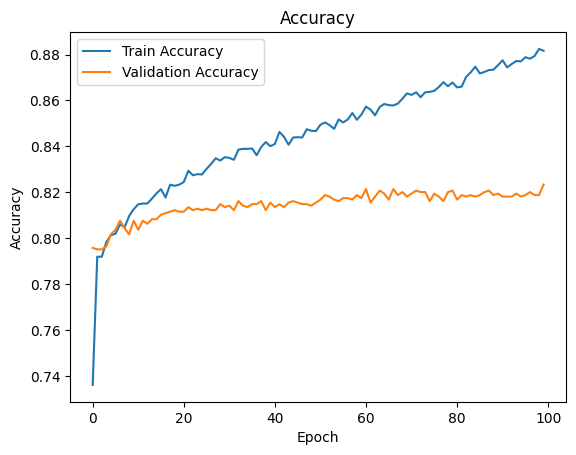

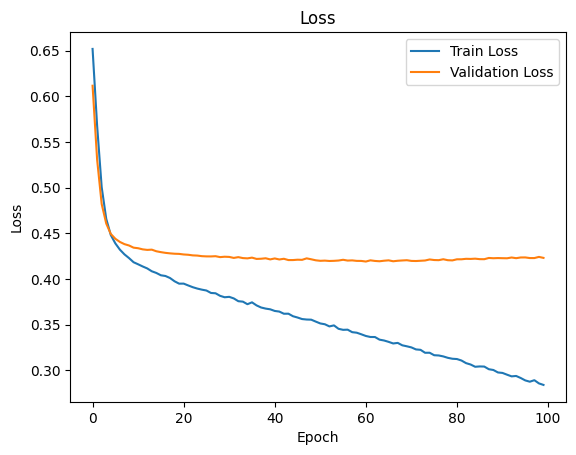

In [136]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training results
plot_training_history(history)


In [137]:
from sklearn.metrics import classification_report

# Predict on validation set
y_val_pred = (classifier.predict(X_val_embeddings) > 0.5).astype(int).flatten()

# Print classification metrics
print("Validation Results:")
print(classification_report(y_val, y_val_pred, target_names=["Not Disaster", "Disaster"]))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Results:
              precision    recall  f1-score   support

Not Disaster       0.83      0.87      0.85       874
    Disaster       0.81      0.76      0.79       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.82      1523
weighted avg       0.82      0.82      0.82      1523



In [138]:
# Generate predictions on the test set
y_test_pred = (classifier.predict(X_test_embeddings) > 0.5).astype(int).flatten()

# Print a few test predictions
print("\nSample Test Predictions:")
for i in range(5):  # Print 5 examples
    print(f"Tweet: {X_test.iloc[i]}")
    print(f"Predicted Label: {'Disaster' if y_test_pred[i] == 1 else 'Not Disaster'}")
    print("-" * 50)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Sample Test Predictions:
Tweet: Just happened a terrible car crash
Predicted Label: Not Disaster
--------------------------------------------------
Tweet: Heard about #earthquake is different cities, stay safe everyone.
Predicted Label: Disaster
--------------------------------------------------
Tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicted Label: Disaster
--------------------------------------------------
Tweet: Apocalypse lighting. #Spokane #wildfires
Predicted Label: Disaster
--------------------------------------------------
Tweet: Typhoon Soudelor kills 28 in China and Taiwan
Predicted Label: Disaster
--------------------------------------------------


In [139]:
# Predict on the test set using the trained model
y_test_pred = (classifier.predict(X_test_embeddings) > 0.5).astype(int).flatten()

# Check the shape of the predictions
print(f"Predictions shape: {y_test_pred.shape}")


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predictions shape: (3263,)


# Generate the submission file

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [140]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'id': df_test['id'],       # Use the ID column from the test dataset
    'target': y_test_pred      # Predicted labels (0 or 1)
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created!")

Submission file 'submission.csv' created!


In [133]:
# Check the first few rows of the submission file
print(submission.head())

# Ensure there are no missing or invalid values
print("Submission file summary:")
print(submission.describe())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
Submission file summary:
                 id       target
count   3263.000000  3263.000000
mean    5427.152927     0.403003
std     3146.427221     0.490577
min        0.000000     0.000000
25%     2683.000000     0.000000
50%     5500.000000     0.000000
75%     8176.000000     1.000000
max    10875.000000     1.000000
